## Семинар 15: "Обучение с подкреплением 2"

ФИО: Дорожинский Владислав Игоревич

###  FrozenLake


<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>



In [1]:
import gym
import numpy as np 
import random
import cv2
from torch import nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import deque
import time

%matplotlib inline

In [2]:
#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

In [3]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


In [7]:
obs_new, reward, done, _ = env.step(0)

### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

## Задание 1.
Подберите значения alpha и epsilon и найдите приближение оптимальной Q-функции для Frozen Lake.

In [133]:

class QLearn:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        oldv = self.q.get((state, action), None)

        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def chooseAction(self, state, is_eval=False):
        if random.random() < self.epsilon and not is_eval:
            action = random.choice(self.actions)
        else:
            q = [self.getQ(state, a) for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma*maxqnew)

In [134]:
def run_episode_qlearn_learn(env, qlearn, gamma=1.0, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        qlearn.learn(obs, action, reward, obs_new)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [136]:
def run_episode_qlearn(env, qlearn, gamma=1.0, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs, is_eval=True)
        obs_new, reward, done, _ = env.step(action)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [137]:
def evaluate_qlearn(env, qlearn, gamma=1.0, n=100):
    scores = [
            run_episode_qlearn(env, qlearn, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

In [168]:
GAMMA = 0.99
qlearn = QLearn(actions=range(env.env.nA), gamma=GAMMA, epsilon=0.1, alpha=0.3)
[run_episode_qlearn_learn(env, qlearn, gamma=GAMMA) for _ in range(1000)];


In [172]:
evaluate_qlearn(env, qlearn, gamma=1.0, n=1000)

0.759

## Задание 2.
Обучите сеть DQN для среды http://gym.openai.com/envs/Pong-v0/ 

* http://www.pinchofintelligence.com/introduction-openai-gym-part-2-building-deep-q-network/
* http://www.pinchofintelligence.com/openai-gym-part-3-playing-space-invaders-deep-reinforcement-learning/
* https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [130]:
env = gym.make("FrozenLake-v0")
env.reset();

In [2]:
class SimpleGame:
    def __init__(self, refresh_every):
        self.refresh_every = refresh_every
        self.state_to_obs = (
            ((1, 0), (0, 1),),
            ((0, 1), (1, 0),),
        )
        
        self.reset()
        
    def refresh(self):
        self.curr_state = 1 - self.curr_state
        self.refresh_counter = 0
    
    def reset(self):
        self.curr_state = 0
        self.refresh_counter = 0
    
    def step(self, action):
        is_term = False
        info = None
        if self.refresh_counter == self.refresh_every:
            self.refresh()
        obs = self.state_to_obs[self.curr_state]
        reward = 1 if action == self.curr_state else -1
        self.refresh_counter += 1
        return obs, reward, is_term, info
    

In [159]:
actions = 2
SHORT_MEMORY_SIZE = 2
N_ACTIONS = actions
IMAGE_DIM = 2

In [175]:
env = SimpleGame(100)

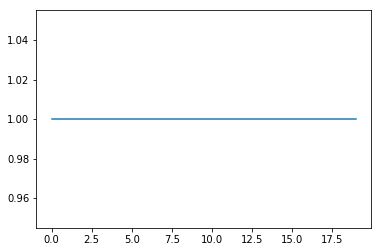

In [176]:
plt.plot([env.step(0)[1] for _ in range(20)]);

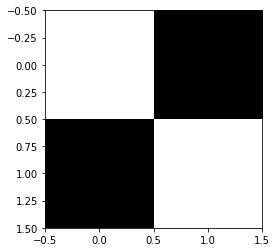

In [177]:
def one_hot(x, n_classes, dtype=np.float64):
    x = np.array(x).reshape(-1)
    res = np.zeros([x.shape[0], n_classes], dtype=dtype)
    res[np.arange(x.shape[0]), x] = 1
    return res

def preprocess(observation):
    return np.array(observation)

def show(img):
    plt.imshow(np.array(np.squeeze(img)), cmap='gray')
    plt.show()
    
action0 = 0
observation0, reward0, terminal, info = env.step(action0)
show(preprocess(observation0))

In [178]:
class DQN(nn.Module):
    def __init__(self, in_channels, output_size):
        super(DQN, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels, 8, 2, stride=1),
                                      nn.ReLU(),
#                                       nn.Conv2d(8, 8, 2, stride=2),
#                                       nn.ReLU(),
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(8, 12),
                                        nn.ReLU(),
                                        nn.Linear(12, output_size)
                                       )
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.features(x)
        x = x.view(-1, 8)
        x = self.classifier(x)
        return x

In [179]:
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1
M = 32
EXPLORE = 1000
REPLAY_MEMORY = 10000
BATCH_SIZE = 32 * M
PRINT_EVERY = 500
GAMMA = 0.95
ALPHA = 1.0
K = 1

class Controller:
    def __init__(self, verbose=False):
        self.epsilon = INITIAL_EPSILON
        self.verbose = verbose
        self.dqn = DQN(SHORT_MEMORY_SIZE, N_ACTIONS).cuda()
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=0.001)
        self.loss_f = nn.MSELoss()
        self.step = 0
        self.replay = deque()
        self.states = deque()
    
        
    def train_step(self):
#         print('>>>ENTER TRAIN STEP')
        self.dqn.train()
        batch_idxs = np.random.randint(SHORT_MEMORY_SIZE, len(self.replay)-1, BATCH_SIZE)
        state_batch = np.zeros([BATCH_SIZE, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
        action_batch = np.zeros([BATCH_SIZE], dtype=np.int32)
        term_batch = np.zeros([BATCH_SIZE], dtype=np.int32)
        reward_batch = np.zeros([BATCH_SIZE], dtype=np.float32)
        y_reward_batch = np.zeros([BATCH_SIZE], dtype=np.float32)
        next_state_batch = np.zeros([BATCH_SIZE, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
        
        for i in range(BATCH_SIZE): # todo: vectorize
            idx = batch_idxs[i]
            action_batch[i] = self.replay[idx][1]
            reward_batch[i] = self.replay[idx][2]
            term_batch[i] = self.replay[idx][3]
            for j in range(SHORT_MEMORY_SIZE):
                state_batch[i,:,:,j] = self.states[idx - j - 1]
                next_state_batch[i,:,:,j] = self.states[idx - j]
        
        next_state_batch = Variable(torch.FloatTensor(next_state_batch)).cuda()
        reward_batch = torch.FloatTensor(reward_batch).cuda()
        term_batch = torch.FloatTensor(term_batch).cuda()
        q_values_pred = self.dqn(next_state_batch)
        q_values_pred = torch.max(q_values_pred, 1)[0].data
#         print('q_values_pred')
#         print(q_values_pred)
#         print('term_batch')
#         print(term_batch)
        y_reward_batch = reward_batch + q_values_pred * (1 - term_batch) * GAMMA
        y_reward_batch = Variable(y_reward_batch, requires_grad=False)
#         print('y_reward_batch')
#         print(y_reward_batch)
                
        action_batch = one_hot(action_batch, N_ACTIONS)
        action_batch = torch.FloatTensor(action_batch).cuda()
        
        state_batch = Variable(torch.FloatTensor(state_batch)).cuda()
        q_values_pred = self.dqn(state_batch)
        q_act_vales = torch.sum(q_values_pred * action_batch, 1)
#         print('q_act_vales')
#         print(q_act_vales)
        loss = self.loss_f(q_act_vales, y_reward_batch)
        loss.backward()
        
        self.optimizer.step()
        self.dqn.zero_grad()
        
        if self.step % PRINT_EVERY == 0:
            rew_true = reward_batch.cpu().data.numpy()
#             print(rew_true[:5])
            rew_true_mean = np.mean(rew_true)
            rew_true_stat = np.min(rew_true), np.max(rew_true)
            rew_true = (y_reward_batch.cpu().data.numpy() < -0.5)
            true_n = np.sum(rew_true)
            rew_pred = q_act_vales.cpu().data.numpy()
#             print(rew_pred[:5])
#             print(q_values_pred.cpu().data.numpy()[:5])
            rew_pred_mean = np.mean(rew_pred)
            rew_pred = (rew_pred < -0.5)
            pred_n = np.sum(rew_pred)
            hit_n = np.sum(rew_true & (rew_pred == rew_true))
            res_str = '[{}] Loss: {:.4f} TrueN: {} PredN: {} HitNegN: {} PredRew: {:.4f} ActRew: {:.4f} Eps: {:.3f}'
            print(res_str.format(self.step,
                                 loss.item(),
                                 true_n,
                                 pred_n,
                                 hit_n,
                                 rew_pred_mean,
                                 rew_true_mean,
                                 self.epsilon
                                ))
#         print('<<<EXIT TRAIN STEP\n')

            
        
    def get_action(self):
        action = -1
        if random.random() <= self.epsilon or len(self.states) < SHORT_MEMORY_SIZE:
            action = np.random.randint(N_ACTIONS)
        else:
            state_batch = np.zeros([1, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
            idx = len(self.states) - 1
            for j in range(SHORT_MEMORY_SIZE):
                state_batch[0,:,:,j] = self.states[idx - j]
            state_batch = Variable(torch.FloatTensor(state_batch)).cuda()
            self.dqn.eval()
            qs = self.dqn(state_batch).cpu().data.numpy()[0]
            action = np.argmax(qs)
        
        self.epsilon = INITIAL_EPSILON - (INITIAL_EPSILON - FINAL_EPSILON) \
            * self.step / EXPLORE if self.epsilon > FINAL_EPSILON else FINAL_EPSILON
        
        return action
    
    def observe(self, new_obs, action, reward, is_terminal):
        self.replay.append((self.step, action, reward, is_terminal))
        self.states.append(new_obs)
        if len(self.replay) > REPLAY_MEMORY: 
            self.replay.popleft()
            self.states.popleft()
        if self.step > 100:
            self.train_step()
        
        self.step += 1

In [180]:
ctrl = Controller()
env.reset();

In [181]:
actionmax = 0
for e in range(100000):
    if e % K == 0:
        actionmax = ctrl.get_action()
    new_obs, reward, is_term, _ = env.step(actionmax)
    if is_term:
        new_obs = env.reset()
        
    if e % K == 0:
        new_obs = preprocess(new_obs).squeeze()
        ctrl.observe(new_obs, actionmax, reward, is_term)

[500] Loss: 0.1109 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 16.8050 ActRew: 0.2773 Eps: 0.550
[1000] Loss: 0.0682 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 18.8798 ActRew: 0.4629 Eps: 0.100
[1500] Loss: 0.0553 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.0514 ActRew: 0.5957 Eps: 0.100
[2000] Loss: 0.0530 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.2552 ActRew: 0.6719 Eps: 0.100
[2500] Loss: 0.0746 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.2694 ActRew: 0.7090 Eps: 0.100
[3000] Loss: 0.0665 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.3560 ActRew: 0.7441 Eps: 0.100
[3500] Loss: 0.0280 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.4032 ActRew: 0.7715 Eps: 0.100
[4000] Loss: 0.0459 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.4490 ActRew: 0.7773 Eps: 0.100
[4500] Loss: 0.0553 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.3972 ActRew: 0.7949 Eps: 0.100
[5000] Loss: 0.0468 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.3573 ActRew: 0.7852 Eps: 0.100
[5500] Loss: 0.0338 TrueN: 0 PredN: 0 HitNegN: 0 PredRew: 19.4061 ActRew: 0.8320 

KeyboardInterrupt: 

In [156]:
action = ctrl.get_action()
new_obs, reward, is_term, _ = env.step(action)
new_obs = preprocess(new_obs).squeeze()
ctrl.observe(new_obs, action, reward, is_term)
show(new_obs);
action, reward

RuntimeError: Given groups=1, weight[8, 2, 2, 2], so expected input[1, 1, 2, 2] to have 2 channels, but got 1 channels instead

In [ ]:
# replay: self.step, action, reward, is_terminal
for e in ctrl.replay:
    if (e[2] > 0.5):
        print(e)

In [152]:
obs = env.reset()

Reward: 0.0, terminal?: False


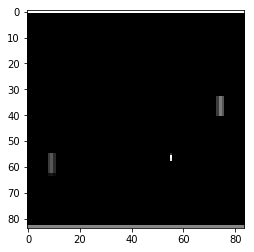

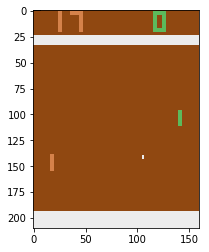

In [10]:
act = act_idle
# act = act_up
# act = act_down
obs, reward, is_term, _ = env.step(act)
print('Reward: {}, terminal?: {}'.format(reward, is_term))
show(preprocess(obs))
show(obs)

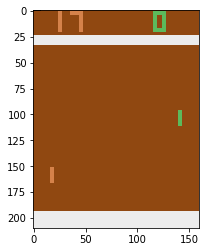

In [185]:
show(obs)